# Fact-checker Feedback Loop with LangGraph on Amazon Bedrock

## 1. Introduction to feedback loops

This solution implements an advanced fact-checking feedback mechanism for AI-generated summaries using LangGraph on Amazon Bedrock. The process begins with an AI model summarizing a given document. The summary then undergoes an evaluation loop where individual claims are extracted and verified against the original text. If any conflicts are found, the system provides specific feedback to the AI, prompting it to revise the summary. This cycle continues for a set number of iterations or until a faithful summary is produced.

The approach is particularly useful in scenarios where accuracy and faithfulness to source material are crucial, such as in report generation in business settings, academic research, or legal document summarization. It helps mitigate the risk of AI hallucinations or misrepresentations by implementing a self-correcting mechanism. This method not only improves the quality of AI-generated content but also provides transparency in the summarization process, which is valuable in building trust in AI systems for critical applications.

![Fact-checker-main](./images/Fact-checker-main.png)

## 2. How fact-checking feedback loop works

It begins with an input document fed into a Summarizer, which produces a summary using a specific prompt. This summary then moves to the Evaluator stage, where it undergoes two steps: first, a Claim Extractor extracts key claims from the summary, and then an Evaluator prompt assesses these claims against the original document. If the evaluation determines the summary is faithful to the original content, the process concludes successfully, outputting the verified summary. 

![Fact-checker-if-faithful.png](./images/Fact-checker-if-faithful.png)

If the Evaluator concludes that the summary is unfaithful, the flow marked in blue text in the diagram is executed. The feedback is appended to the Summarizer chat as a human message. The Summarizer then uses this feedback to generate a revised summary. The revised summary proceeds to another evaluation by the Evaluator. If it's identified as faithful, the graph execution finishes with the revised summary.

![Fact-checker-if-not-faithful.png](./images/Fact-checker-if-not-faithful.png)

The summarization process incorporates a feedback and evaluation loop that iterates up to a predefined number (N) of attempts. The system strives to generate a faithful summary within these iterations. If a faithful summary is achieved at any point, the process concludes successfully. However, if after N attempts a faithful summary has not been produced, the process terminates with a fail response, clearly indicating that the goal was not met. This approach prioritizes accuracy over completion, opting to acknowledge failure rather than provide an unfaithful summary. It ensures that any summary output by the system meets a high standard of faithfulness to the original document.


![Fact-checker-faithful-check-n-times.png](./images/Fact-checker-faithful-check-n-times.png)

## 3. Implement fact-checking

### 3.1. Configuration

Install packages required

In [ ]:
%pip install langgraph langchain langchain_aws Pillow --quiet

Import the required packages

In [1]:
import pprint
import io
from pathlib import Path

from typing import Literal, NotRequired, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_aws import ChatBedrockConverse
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages

from PIL import Image

Set langchain debug to True, this simplifies demonstration of the execution flow

In [2]:
from langchain.globals import set_debug
# Set debug mode for Langchain
set_debug(True)

In [3]:
MAX_ITERATIONS = 3

Setup AWS Python SDK (boto3) to access Amazon Bedrock resources

In [4]:
import boto3 
import botocore

# Configure Bedrock client for retry
retry_config = botocore.config.Config(
    retries = {
        'max_attempts': 10,
        'mode': 'adaptive'
    }
)

In [5]:
# ---- ⚠️ Un-comment or comment and edit the below lines as needed for your AWS setup ⚠️ ----
import os

os.environ["AWS_DEFAULT_REGION"] = "us-east-1" 
os.environ["AWS_PROFILE"] = "default"

bedrock_runtime = boto3.client('bedrock-runtime', config=retry_config)

llm = ChatBedrockConverse(
    model='anthropic.claude-3-haiku-20240307-v1:0',
    temperature=0,
    max_tokens=None,
    client=bedrock_runtime,
)

Validate that boto3 and langchain works well

In [6]:
llm.invoke("Hello world")

[llm/start] [llm:ChatBedrockConverse] Entering LLM run with input:
{
  "prompts": [
    "Human: Hello world"
  ]
}
[llm/end] [llm:ChatBedrockConverse] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Hello! It's nice to meet you.",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "Hello! It's nice to meet you.",
            "response_metadata": {
              "ResponseMetadata": {
                "RequestId": "0a11183b-719f-42b4-86f9-aac9a9558454",
                "HTTPStatusCode": 200,
                "HTTPHeaders": {
                  "date": "Tue, 01 Oct 2024 21:25:39 GMT",
                  "content-type": "application/json",
                  "content-length": "209",
                  "co

AIMessage(content="Hello! It's nice to meet you.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '0a11183b-719f-42b4-86f9-aac9a9558454', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 01 Oct 2024 21:25:39 GMT', 'content-type': 'application/json', 'content-length': '209', 'connection': 'keep-alive', 'x-amzn-requestid': '0a11183b-719f-42b4-86f9-aac9a9558454'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': 346}}, id='run-96740601-c85e-4959-aa7a-79e3b0d8b7bb-0', usage_metadata={'input_tokens': 9, 'output_tokens': 12, 'total_tokens': 21})

Configure prompts for each task

In [22]:

summarizer_prompt = """
Document to be summarized:
\"\"\"
{doc_input}
\"\"\"

Summarize the provided document. Keep it clear and concise but do not skip any significant detail. 
IMPORTANT: Provide only the summary as the response, without any preamble.
"""

summarizer_prompt_t = PromptTemplate.from_template(summarizer_prompt)

claim_extractor_prompt = """
LLM-generated summary:
\"\"\"
{summary}
\"\"\"
Extract all the claims from the provided summary. Extract every and every claim from the summary, never miss anything.
Each claim should be atomic, containing only one distinct piece of information. 
These claims will later be used to evaluate the factual accuracy of the LLM-provided summary compared to the original content. 
Your task is solely to extract the claims from the summary. 
Present the output as a JSON list of strings, where each string represents one claim from the summary. 
Respond only with a valid JSON, nothing else, without any preamble.
"""

claim_extractor_prompt_t = PromptTemplate.from_template(claim_extractor_prompt)

evaluator_prompt = """
You are a Principal Editor at a prestigious publishing company. Your task is to evaluate whether an LLM-generated summary is faithful to the original document.

You will be presented with:
1. The original document content
2. Claims extracted from the LLM-generated summary

Instructions:
1. Carefully read the original document content.
2. Examine each extracted claim from the summary individually.
3. For each claim, determine if it is accurately represented in the original document. Express your thinking and reasoning.
4. After evaluating all claims, provide a single JSON output with the following structure (markdown json formatting: triple backticks and "json"):
```json
{{
"is_faithful": boolean,
"reason": "string" [Optional]
}}
```
Important notes:
- The "is_faithful" value should be true only if ALL extracted claims are accurately represented in the original document.
- If even one claim is not faithful to the original content, set "is_faithful" to false.
- When "is_faithful" is false, provide a clear explanation in the "reason" field, specifying which claim(s) are not faithful and why.
- The "reason" field is optional when "is_faithful" is true.
- The output should contain only one JSON output. This is how the software will parse your response. If you're responding with multiple JSON statements in your response, you're doing it wrong.
The original document (the source of truth):
\"\"\"
{doc_input}
\"\"\"
Extracted claims from the LLM-generated summary:
\"\"\"
{claims_list}
\"\"\"
Please proceed by explaining your evaluation for each claim based on the source content. Then finalize with a single JSON output in markdown json formatting (triple backticks and "json"). Think step by step.
"""

evaluator_prompt_t = PromptTemplate.from_template(evaluator_prompt)

feedback_prompt = """
I gave your generated summary to our content review department, and they rejected it. Here is the feedback I received:

\"\"\"
The generated summary is not faithful. Reason: {reason}
\"\"\"

Now, please incorporate this feedback and regenerate the summary.
IMPORTANT: Do not start with any preamble. Provide only the revised summary as your response.
"""

feedback_prompt_t = PromptTemplate.from_template(feedback_prompt)


Define nodes, and the State class to pass data between nodes

In [23]:

class State(TypedDict):
    messages: Annotated[list, add_messages]
    doc_input: str
    is_faithful: NotRequired[bool]
    reason: NotRequired[list[str]]
    num_of_iterations: NotRequired[int]

def summarizer(state: State):
    print("summarizer() invoked")

    if "is_faithful" in state and state["is_faithful"] == False:
        state["messages"].append(HumanMessage(content=feedback_prompt_t.format(reason=state["reason"][-1])))
    else:
        state["messages"].append(HumanMessage(content=summarizer_prompt_t.format(doc_input=state["doc_input"])))

    result = llm.invoke(state["messages"])
    state["messages"].append(result)

    return state

def evaluator(state: State):
    print("evaluator() invoked")

    claim_extractor_chain = claim_extractor_prompt_t | llm | JsonOutputParser()
    result = claim_extractor_chain.invoke({"summary": state["messages"][-1].content})
    evaluator_chain = evaluator_prompt_t | llm | JsonOutputParser()
    evaluator_result = evaluator_chain.invoke({"doc_input": state["doc_input"], "claims_list": result})

    if evaluator_result["is_faithful"]:
        state["is_faithful"] = True
    else:
        state["is_faithful"] = False
        if "reason" not in state:
            state["reason"] = []
        state["reason"].append(evaluator_result["reason"])

    if "num_of_iterations" not in state:
        state["num_of_iterations"] = 0
    
    state["num_of_iterations"] += 1
    return state


Build the graph with a feedback loop

In [24]:

builder = StateGraph(State)
builder.add_node("summarizer", summarizer)
builder.add_node("evaluator", evaluator)
# summarizer -> evaluator
builder.add_edge("summarizer", "evaluator")

def feedback_loop(state: State) -> Literal["summarizer", "__end__"]:
    if state["is_faithful"] is False:
        # in our case, we'll just stop after N plans
        if state["num_of_iterations"] >= MAX_ITERATIONS:
            print("Going to end!")
            return END
        return "summarizer"
    else:
        return END

builder.add_conditional_edges("evaluator", feedback_loop)
builder.add_edge(START, "summarizer")
graph = builder.compile()

Save graph image as a file. It should be as the following:

![graph](images/graph.png)

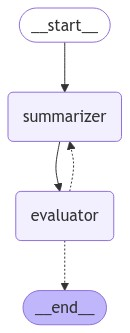

In [25]:
import IPython

try:
    IPython.display.display(IPython.display.Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

You can also save the most up to date graph image using the following code.

In [26]:

# save graph image as a file
graph_path = "images/graph.png"
graph_path = Path(graph_path)
image_data = io.BytesIO(graph.get_graph().draw_mermaid_png())
image = Image.open(image_data)
image.save(graph_path)


### 3.2. Invoke the graph with an input document
The input document is an LLM-generated document, intentionally tricky to challenge the LLM's summarization abilities. Using the `anthropic.claude-3-haiku` model, this should fail in the fact-checker on the first attempt but should correct itself on the second attempt. You can also experiment with producing a failure output by setting `MAX_ITERATIONS = 1`, assuming it will fail on the first attempt.


In [27]:
doc_input = """
The company's new product line, codenamed "Project Aurora," has been in development for several years. However, due to unforeseen circumstances, we have decided to cancel Project Aurora and focus on other initiatives. Meanwhile, our team has been working tirelessly to bring Project Aurora to market, and we're excited to announce its launch next quarter. In fact, we've already begun taking pre-orders for the product, which is expected to revolutionize the industry. But wait, there's more: Project Aurora was never actually a real project, and we've just been using it as a placeholder name for our internal testing purposes. Or have we? Some sources close to the company suggest that Project Aurora is, in fact, a highly classified initiative that's been hiding in plain sight. Others claim that it's simply a rebranding of our existing product line. One thing is certain, though: Project Aurora is not what it seems. 
"""

In [28]:
initial_state: State = {
    "messages": [],
    "doc_input": doc_input,
}

event = graph.invoke(initial_state)

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [],
  "doc_input": "\nThe company's new product line, codenamed \"Project Aurora,\" has been in development for several years. However, due to unforeseen circumstances, we have decided to cancel Project Aurora and focus on other initiatives. Meanwhile, our team has been working tirelessly to bring Project Aurora to market, and we're excited to announce its launch next quarter. In fact, we've already begun taking pre-orders for the product, which is expected to revolutionize the industry. But wait, there's more: Project Aurora was never actually a real project, and we've just been using it as a placeholder name for our internal testing purposes. Or have we? Some sources close to the company suggest that Project Aurora is, in fact, a highly classified initiative that's been hiding in plain sight. Others claim that it's simply a rebranding of our existing product line. One thing is certain, though: Project Auro

Print the resulting event state

In [29]:
print(pprint.pp(event))


{'messages': [HumanMessage(content='\nDocument to be summarized:\n"""\n\nThe company\'s new product line, codenamed "Project Aurora," has been in development for several years. However, due to unforeseen circumstances, we have decided to cancel Project Aurora and focus on other initiatives. Meanwhile, our team has been working tirelessly to bring Project Aurora to market, and we\'re excited to announce its launch next quarter. In fact, we\'ve already begun taking pre-orders for the product, which is expected to revolutionize the industry. But wait, there\'s more: Project Aurora was never actually a real project, and we\'ve just been using it as a placeholder name for our internal testing purposes. Or have we? Some sources close to the company suggest that Project Aurora is, in fact, a highly classified initiative that\'s been hiding in plain sight. Others claim that it\'s simply a rebranding of our existing product line. One thing is certain, though: Project Aurora is not what it seems

Show the final result

In [30]:
if event["is_faithful"]:
    print("The generated summary is faithful to the original document.")
    print("The summary:")
    print("====")
    print(event["messages"][-1].content)
    print("====")
    print(f"Number of iterations used: {event['num_of_iterations']}")

else:
    print("The generated summary is not faithful to the original document.")
    print("List of the reasons for the rejection:")
    print("====")
    print(event["reason"])
    print("====")

The generated summary is faithful to the original document.
The summary:
====
The company's new product line, codenamed "Project Aurora," has been in development for several years. However, due to unforeseen circumstances, the company has decided to cancel Project Aurora and focus on other initiatives. The document reveals conflicting information about the nature of Project Aurora, with some sources suggesting it is a highly classified initiative, while others claim it is a rebranding of the company's existing product line. The document concludes that Project Aurora is not what it seems.
====
Number of iterations used: 2


## 4. Conclusion

This notebook shows how to build a fact-checking system for AI summaries using LangGraph and Amazon Bedrock. It creates a loop that checks if a summary is accurate, and if not, tries to fix it. This helps make AI-generated content more reliable by catching and correcting mistakes. The system is useful for tasks where accuracy is important, like in business reports or legal documents. It demonstrates a practical way to improve AI summaries and make them more trustworthy.

You can extend and adapt this method to your specific use cases, implementing a feedback-loop control mechanism to achieve more deterministic and trustworthy responses from LLMs